In [1]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
import time
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50

In [2]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =448
        self.n_augment = max(n_augment , 4)
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224)),
                transforms.RandomRotation(5),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ]
            )
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

In [3]:
# del training_dataloader
batch_size = 128
lr = 0.1
suffix = '%f' % time.time()
log_dir = './log/%s'% suffix +'/'
EXPERIMENT = 'resnet50_%s'% str(lr)
os.mkdir(log_dir)
print(suffix)
print(log_dir)
print(EXPERIMENT)

training_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)

1593759845.609134
./log/1593759845.609134/
resnet50_0.1


In [4]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every  iterations, print loss
        if (i + 1) % (10) == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [5]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy,cm

In [6]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [7]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    cms = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy,cm = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        cms.append(cm)
    torch.save(model.state_dict(), log_dir+EXPERIMENT+".pth")
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [8]:
net = resnet50(pretrained=True)
net.fc = torch.nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(inplace=True),
                             nn.Dropout(p=0.6),
                             nn.Linear(512, 40)
                            )

In [9]:
# Hyper-parameters
num_epochs = 40
nclasses = 40
feature_tune=False
# Device configuration
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


for parma in net.parameters():
    parma.requires_grad = feature_tune
for param in net.fc.parameters():
    param.requires_grad = True
for param in net.avgpool.parameters():
    param.requires_grad = True
for param in net.layer4.parameters():
    param.requires_grad = True

# # optimizer
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 4 , gamma = 0.5)
#for name,param in net.named_parameters():
#    print(param.requires_grad, name)

Epoch 1/40: , lr = 0.1
Step [10/60] Train Loss: 3.6428
Step [20/60] Train Loss: 3.3756
Step [30/60] Train Loss: 3.1431
Step [40/60] Train Loss: 2.9197
Step [50/60] Train Loss: 2.5199
Step [60/60] Train Loss: 2.2262
Accuracy on Test Set: 35.1042 %


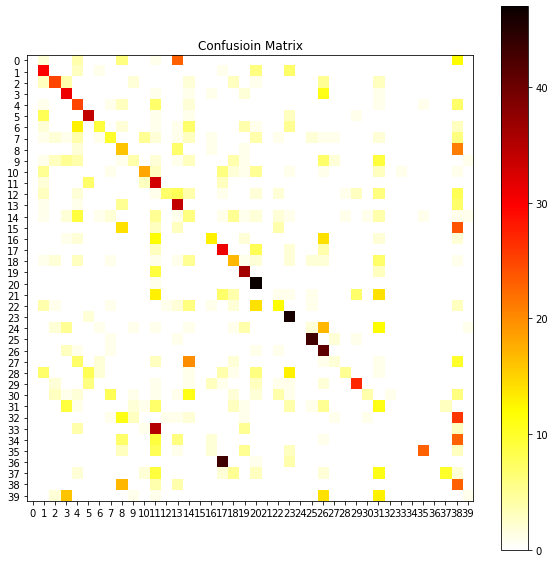

Accuracy of each class:
 tensor([0.0000, 0.6250, 0.5208, 0.6458, 0.5208, 0.7083, 0.1875, 0.2083, 0.3333,
        0.0833, 0.3750, 0.6875, 0.1458, 0.7083, 0.1250, 0.0000, 0.2708, 0.6458,
        0.3542, 0.7500, 0.9792, 0.0000, 0.2500, 0.9583, 0.0000, 0.8958, 0.8542,
        0.0417, 0.1042, 0.5625, 0.0833, 0.2292, 0.0000, 0.0000, 0.0000, 0.4792,
        0.0000, 0.2083, 0.4792, 0.0208])
Recall of each class:
 tensor([0.0000, 0.4167, 0.5952, 0.3974, 0.2809, 0.5965, 0.5294, 0.3704, 0.1882,
        0.2857, 0.6000, 0.1854, 0.7778, 0.3542, 0.0789, 0.0000, 0.5417, 0.3100,
        0.3333, 0.5538, 0.4352, 0.0000, 0.4286, 0.4894, 0.0000, 0.8269, 0.3203,
        0.2500, 0.7143, 0.6923, 0.6667, 0.1058, 0.0000, 0.0000, 0.0000, 0.9200,
        0.0000, 0.7692, 0.1198, 0.2500])
Epoch 2/40: , lr = 0.1
Step [10/60] Train Loss: 2.1290
Step [20/60] Train Loss: 2.1066
Step [30/60] Train Loss: 1.8808
Step [40/60] Train Loss: 1.8647
Step [50/60] Train Loss: 1.5358
Step [60/60] Train Loss: 1.4533
Accuracy on Tes

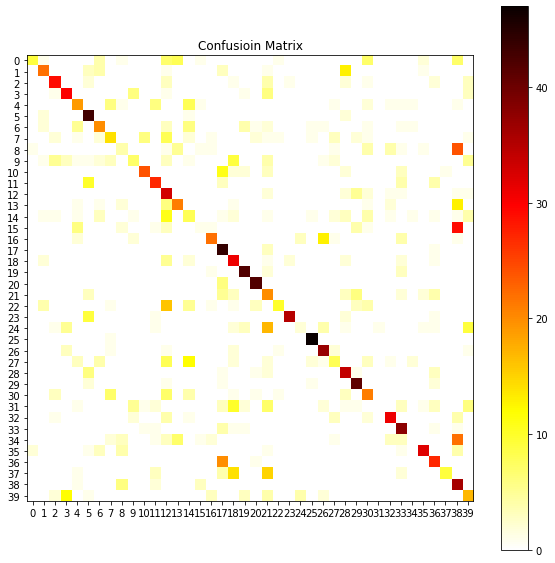

Accuracy of each class:
 tensor([0.1875, 0.4583, 0.6042, 0.6250, 0.3958, 0.8958, 0.4167, 0.2917, 0.0833,
        0.1458, 0.5000, 0.5625, 0.6875, 0.4375, 0.1667, 0.0208, 0.4583, 0.9167,
        0.6458, 0.8750, 0.8750, 0.4167, 0.2083, 0.7292, 0.0417, 0.9792, 0.7708,
        0.1667, 0.7083, 0.8542, 0.4375, 0.0000, 0.6458, 0.7917, 0.0000, 0.6667,
        0.5625, 0.1875, 0.7500, 0.3542])
Recall of each class:
 tensor([0.7500, 0.6286, 0.6444, 0.5660, 0.4524, 0.5309, 0.4651, 0.4000, 0.1739,
        0.3043, 0.7500, 0.6000, 0.2640, 0.5122, 0.1600, 0.1250, 0.6875, 0.4151,
        0.3780, 0.7241, 0.8235, 0.2041, 0.7143, 0.9211, 0.2222, 0.8868, 0.6066,
        0.3333, 0.4857, 0.6508, 0.3889, 0.0000, 0.7045, 0.5507, 0.0000, 0.8000,
        0.5294, 0.9000, 0.2500, 0.3400])
Epoch 3/40: , lr = 0.1
Step [10/60] Train Loss: 1.6714
Step [20/60] Train Loss: 1.1925
Step [30/60] Train Loss: 1.4020
Step [40/60] Train Loss: 1.0138
Step [50/60] Train Loss: 1.4377
Step [60/60] Train Loss: 1.0731
Accuracy on Tes

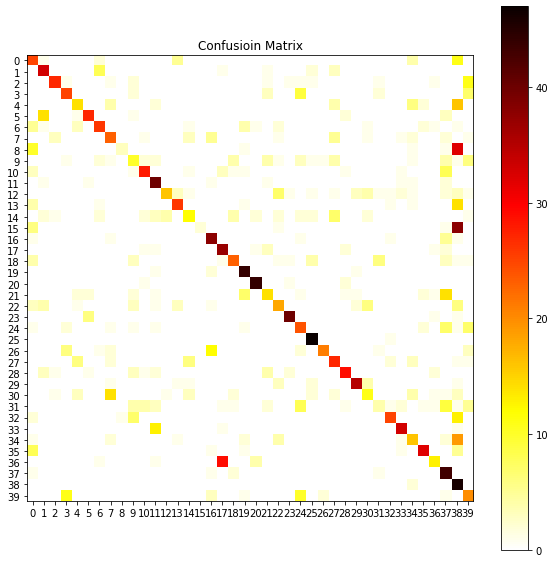

Accuracy of each class:
 tensor([0.5208, 0.6875, 0.5625, 0.5208, 0.2917, 0.5625, 0.5417, 0.4792, 0.0625,
        0.2083, 0.5833, 0.8333, 0.3333, 0.5417, 0.2500, 0.0417, 0.7917, 0.7708,
        0.4792, 0.9167, 0.9167, 0.2917, 0.3750, 0.8333, 0.5000, 0.9792, 0.4375,
        0.5625, 0.6042, 0.7292, 0.2292, 0.0833, 0.5208, 0.6875, 0.3333, 0.6667,
        0.2708, 0.8958, 0.9583, 0.4167])
Recall of each class:
 tensor([0.3378, 0.5593, 0.8182, 0.5435, 0.4667, 0.7297, 0.6047, 0.4423, 0.7500,
        0.2564, 0.7000, 0.5634, 0.7619, 0.6667, 0.4286, 1.0000, 0.5938, 0.5068,
        0.6216, 0.6984, 0.8462, 0.4242, 0.4500, 0.8696, 0.3934, 0.7581, 0.8750,
        0.5094, 0.7632, 0.8333, 0.3793, 0.2500, 0.7812, 0.7857, 0.3810, 0.7805,
        0.5909, 0.3909, 0.2130, 0.3125])
Epoch 4/40: , lr = 0.1
Step [10/60] Train Loss: 1.1287
Step [20/60] Train Loss: 1.0295
Step [30/60] Train Loss: 1.0337
Step [40/60] Train Loss: 0.8646
Step [50/60] Train Loss: 0.9937
Step [60/60] Train Loss: 0.8446
Accuracy on Tes

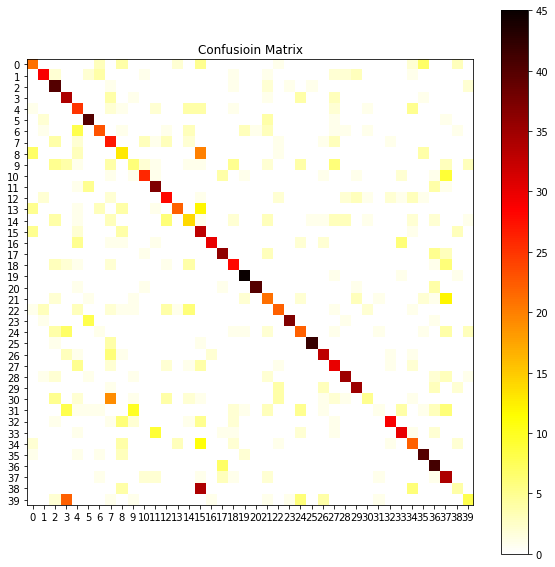

Accuracy of each class:
 tensor([0.4375, 0.6042, 0.8333, 0.7083, 0.5208, 0.8333, 0.4792, 0.5625, 0.2708,
        0.1250, 0.5417, 0.7708, 0.5833, 0.4583, 0.2917, 0.6875, 0.6250, 0.7500,
        0.5833, 0.9375, 0.8333, 0.4375, 0.4583, 0.7708, 0.4583, 0.8750, 0.6875,
        0.6250, 0.7292, 0.7292, 0.1042, 0.0208, 0.6042, 0.6250, 0.4583, 0.8333,
        0.8542, 0.7083, 0.0833, 0.1667])
Recall of each class:
 tensor([0.4884, 0.7436, 0.5333, 0.4250, 0.3846, 0.6897, 0.6216, 0.3253, 0.2766,
        0.2400, 0.7222, 0.6727, 0.5714, 0.7857, 0.3684, 0.2463, 0.9091, 0.6923,
        0.5957, 0.8182, 0.9756, 0.4200, 0.5946, 0.9487, 0.4681, 0.9545, 0.7021,
        0.5172, 0.7778, 0.7609, 0.4545, 0.2000, 0.8286, 0.6818, 0.4583, 0.7018,
        0.5775, 0.4146, 0.2500, 0.4444])
Epoch 5/40: , lr = 0.05
Step [10/60] Train Loss: 0.6998
Step [20/60] Train Loss: 0.6255
Step [30/60] Train Loss: 0.6842
Step [40/60] Train Loss: 0.6500
Step [50/60] Train Loss: 0.5244
Step [60/60] Train Loss: 0.7747
Accuracy on Te

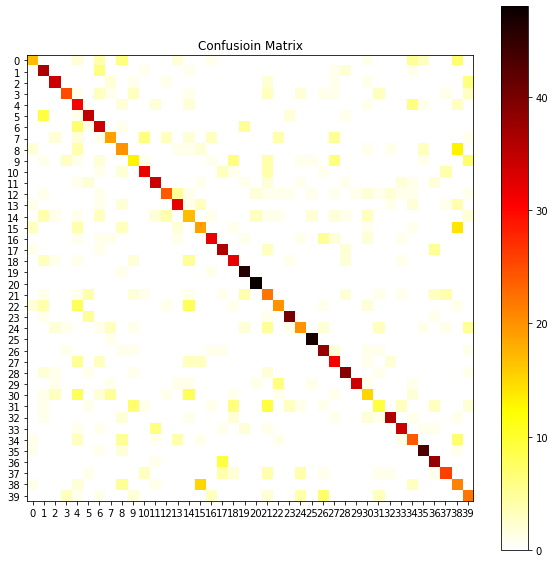

Accuracy of each class:
 tensor([0.3542, 0.7500, 0.7083, 0.5208, 0.6458, 0.7292, 0.7083, 0.3958, 0.4167,
        0.2708, 0.6667, 0.7083, 0.5000, 0.6667, 0.3542, 0.3958, 0.6667, 0.7500,
        0.6667, 0.9583, 1.0000, 0.4583, 0.4167, 0.8333, 0.4167, 0.9792, 0.7917,
        0.6458, 0.8125, 0.7083, 0.3125, 0.1875, 0.7500, 0.7083, 0.5000, 0.8958,
        0.7917, 0.5417, 0.4375, 0.4583])
Recall of each class:
 tensor([0.5862, 0.5538, 0.7556, 0.7576, 0.3605, 0.7000, 0.5075, 0.5758, 0.3846,
        0.3939, 0.7111, 0.7234, 0.7059, 0.6667, 0.3208, 0.4318, 0.7273, 0.6545,
        0.6154, 0.7541, 0.8889, 0.3333, 0.5882, 0.8333, 0.5882, 0.9038, 0.6667,
        0.5741, 0.7800, 0.9714, 0.4412, 0.3750, 0.8372, 0.7727, 0.5000, 0.8113,
        0.7037, 0.7027, 0.2917, 0.4314])
Epoch 6/40: , lr = 0.05
Step [10/60] Train Loss: 0.6753
Step [20/60] Train Loss: 0.5137
Step [30/60] Train Loss: 0.6917
Step [40/60] Train Loss: 0.5973
Step [50/60] Train Loss: 0.7169
Step [60/60] Train Loss: 0.6090
Accuracy on Te

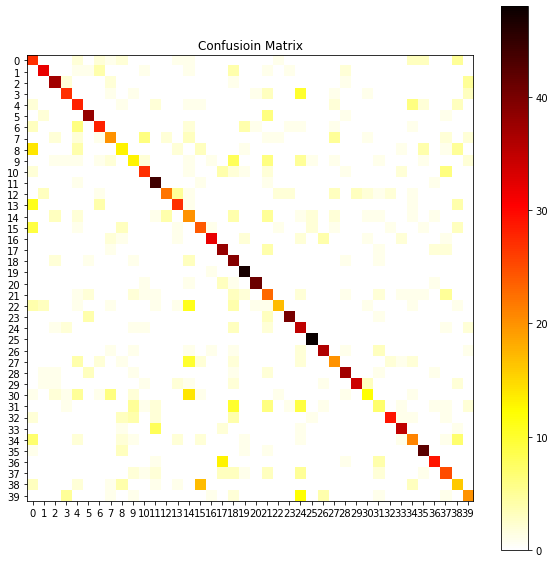

Accuracy of each class:
 tensor([0.5625, 0.6667, 0.7708, 0.5625, 0.5833, 0.7917, 0.5833, 0.4167, 0.2708,
        0.2708, 0.5625, 0.9167, 0.4583, 0.5625, 0.4167, 0.5000, 0.6667, 0.7917,
        0.8125, 0.9792, 0.8542, 0.4792, 0.3542, 0.8333, 0.7292, 1.0000, 0.7500,
        0.4167, 0.7708, 0.7083, 0.2500, 0.1458, 0.6042, 0.7292, 0.4375, 0.8750,
        0.6042, 0.5208, 0.3333, 0.4167])
Recall of each class:
 tensor([0.3140, 0.7619, 0.7400, 0.6923, 0.4444, 0.7755, 0.6364, 0.5128, 0.3824,
        0.3714, 0.6429, 0.6769, 0.7857, 0.6279, 0.2740, 0.4706, 0.8649, 0.6032,
        0.4149, 0.7833, 0.9318, 0.3286, 0.7391, 0.8889, 0.3977, 0.8889, 0.7826,
        0.5556, 0.7872, 0.9189, 0.5455, 0.2692, 0.8529, 0.7778, 0.4884, 0.7636,
        0.8056, 0.5208, 0.3404, 0.5405])
Epoch 7/40: , lr = 0.05
Step [10/60] Train Loss: 0.6916
Step [20/60] Train Loss: 0.7429
Step [30/60] Train Loss: 0.5869
Step [40/60] Train Loss: 0.4123
Step [50/60] Train Loss: 0.6699
Step [60/60] Train Loss: 0.6794
Accuracy on Te

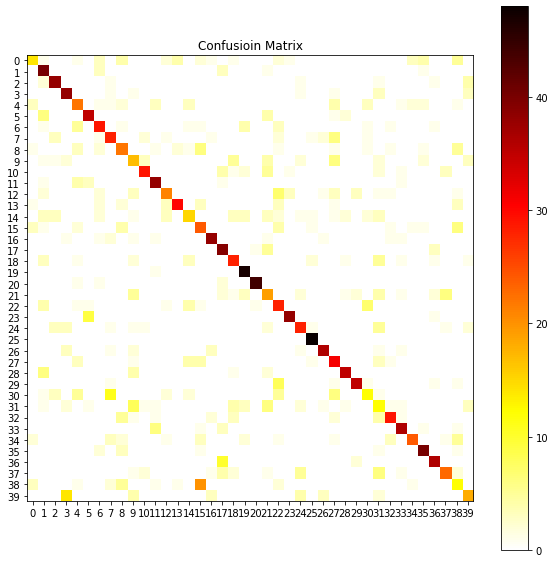

Accuracy of each class:
 tensor([0.2917, 0.8333, 0.7917, 0.7917, 0.4583, 0.7292, 0.6042, 0.5833, 0.4583,
        0.3542, 0.6042, 0.7917, 0.4375, 0.6250, 0.3125, 0.5000, 0.7917, 0.8125,
        0.5833, 0.9792, 0.9167, 0.3958, 0.5833, 0.7917, 0.5833, 1.0000, 0.7500,
        0.6458, 0.7292, 0.7292, 0.2500, 0.2500, 0.6042, 0.7500, 0.5000, 0.8333,
        0.7500, 0.4792, 0.2500, 0.3750])
Recall of each class:
 tensor([0.5185, 0.5479, 0.7451, 0.6032, 0.4490, 0.7143, 0.5918, 0.5385, 0.4400,
        0.3269, 0.7632, 0.7170, 0.6176, 0.8108, 0.4545, 0.3636, 0.7755, 0.5735,
        0.5714, 0.7344, 0.9565, 0.3585, 0.4118, 0.8837, 0.5957, 0.8727, 0.8182,
        0.4769, 0.8333, 0.8333, 0.4286, 0.2143, 0.7436, 0.7826, 0.7742, 0.7692,
        0.7826, 0.6765, 0.2791, 0.5294])
Epoch 8/40: , lr = 0.05
Step [10/60] Train Loss: 0.4720
Step [20/60] Train Loss: 0.3662
Step [30/60] Train Loss: 0.4968
Step [40/60] Train Loss: 0.5353
Step [50/60] Train Loss: 0.4168
Step [60/60] Train Loss: 0.4217
Accuracy on Te

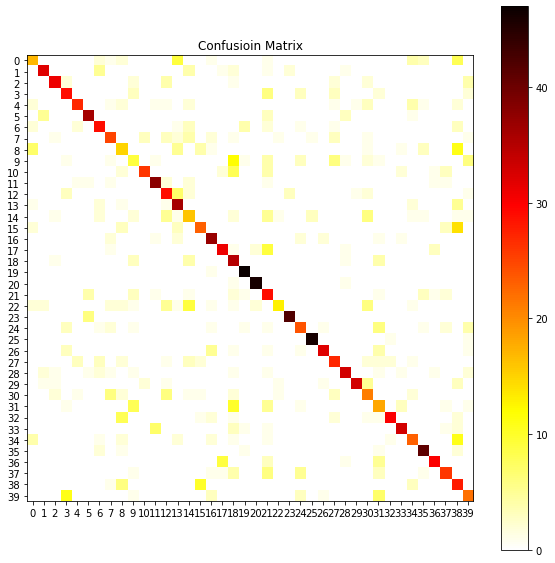

Accuracy of each class:
 tensor([0.3542, 0.6667, 0.6458, 0.6042, 0.5625, 0.7500, 0.6042, 0.5208, 0.3125,
        0.1875, 0.5417, 0.7917, 0.6042, 0.7500, 0.3333, 0.4792, 0.7708, 0.6458,
        0.7292, 0.9792, 0.9583, 0.6042, 0.2708, 0.8750, 0.5000, 0.9583, 0.6667,
        0.5625, 0.6875, 0.6875, 0.4375, 0.3750, 0.6250, 0.6875, 0.4792, 0.8542,
        0.6250, 0.5417, 0.5833, 0.4583])
Recall of each class:
 tensor([0.4595, 0.7619, 0.8158, 0.5472, 0.7941, 0.7500, 0.5918, 0.5682, 0.3125,
        0.2571, 0.8387, 0.7755, 0.5000, 0.5217, 0.3137, 0.5610, 0.6491, 0.7045,
        0.3933, 0.8393, 0.9200, 0.3452, 0.7647, 0.8936, 0.5581, 0.9200, 0.8649,
        0.5625, 0.7857, 0.9429, 0.4038, 0.3158, 0.8824, 0.8049, 0.5476, 0.7593,
        0.8108, 0.6667, 0.3043, 0.4783])
Epoch 9/40: , lr = 0.025
Step [10/60] Train Loss: 0.3257
Step [20/60] Train Loss: 0.3952
Step [30/60] Train Loss: 0.3551
Step [40/60] Train Loss: 0.3904
Step [50/60] Train Loss: 0.3086
Step [60/60] Train Loss: 0.3884
Accuracy on T

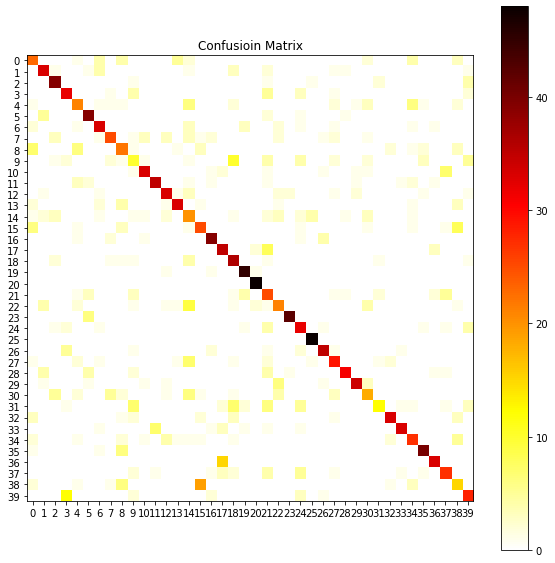

Accuracy of each class:
 tensor([0.4792, 0.6875, 0.8125, 0.6667, 0.4375, 0.8125, 0.6875, 0.5208, 0.4583,
        0.2083, 0.6875, 0.7292, 0.6875, 0.6875, 0.4167, 0.5208, 0.8125, 0.7292,
        0.7500, 0.9375, 1.0000, 0.5208, 0.4375, 0.8750, 0.6667, 1.0000, 0.7292,
        0.6042, 0.6458, 0.7083, 0.3750, 0.2500, 0.6875, 0.6875, 0.5625, 0.8333,
        0.6875, 0.5625, 0.3125, 0.5833])
Recall of each class:
 tensor([0.4510, 0.6600, 0.7091, 0.5926, 0.4884, 0.6964, 0.6471, 0.6579, 0.4151,
        0.2500, 0.8049, 0.8140, 0.7021, 0.7674, 0.2941, 0.4717, 0.7800, 0.5833,
        0.5217, 0.8036, 0.9057, 0.3333, 0.5122, 0.9333, 0.5246, 0.8889, 0.7955,
        0.6304, 0.8857, 0.8718, 0.4737, 0.6667, 0.8250, 0.8919, 0.5625, 0.8163,
        0.8049, 0.6279, 0.3488, 0.5714])
Epoch 10/40: , lr = 0.025
Step [10/60] Train Loss: 0.3079
Step [20/60] Train Loss: 0.5155
Step [30/60] Train Loss: 0.4948
Step [40/60] Train Loss: 0.4073


In [ ]:
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #

In [ ]:
training_dataset[0]